<a href="https://colab.research.google.com/github/gpandji/stock-prediction/blob/main/LMT_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1378087110.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  lmt = yf.download("LMT", start="2000-01-01", end="2025-02-07")
[*********************100%***********************]  1 of 1 completed

Creating features...
✓ Dataset ready: 6107 rows, 21 columns
Using 15 features
Training samples: 4885
Testing samples: 1222

Training Gradient Boosting model...


✓ Training complete!

MODEL PERFORMANCE (7-day prediction)
Training MAE: $1.00
Testing MAE:  $88.27
Training R²:  1.000
Testing R²:   -1.669

Average error: 22.56% of stock price

TOP 10 MOST IMPORTANT FEATURES
       Feature  Importance
        MA_200    0.476743
         MA_50    0.250965
   Close_lag10    0.160430
    Close_lag1    0.095163
         MA_10    0.013500
    Close_lag5    0.001847
Volatility_30d    0.000388
         Month    0.000355
           RSI    0.000236
Volatility_10d    0.000133


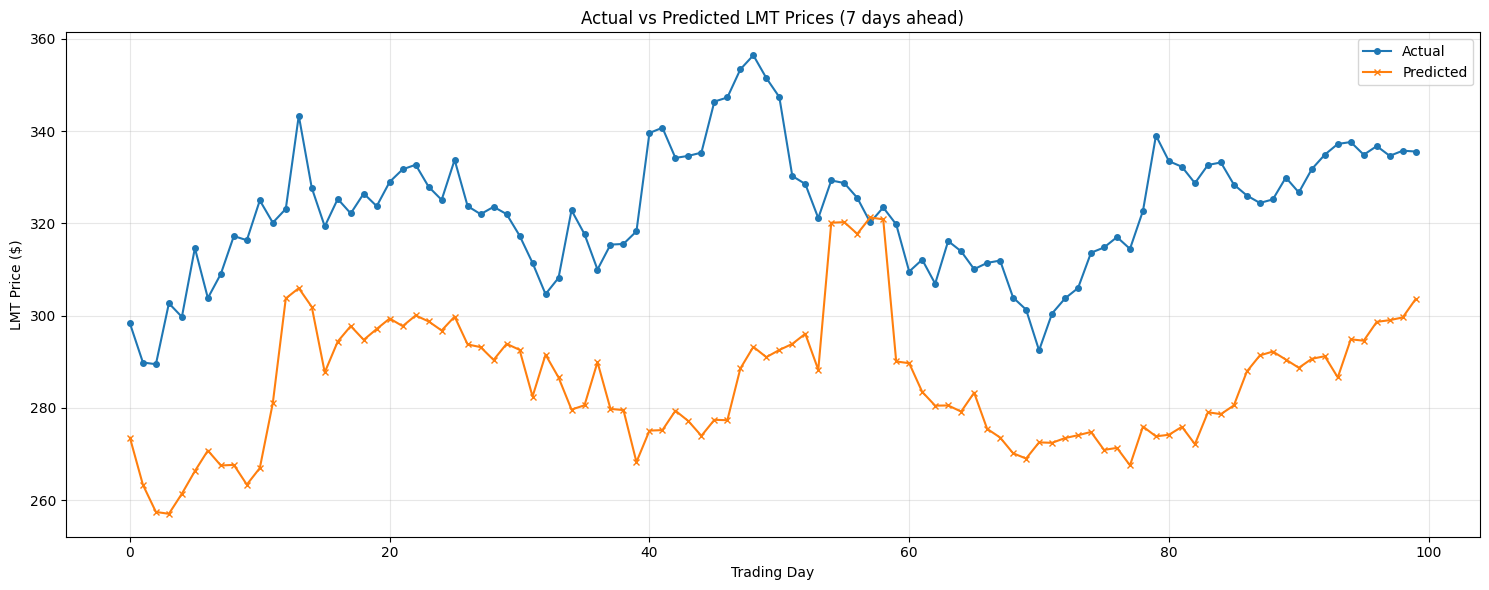


NEXT 7-DAY PREDICTION
Current LMT price: $444.35
Predicted price (7 days): $276.74
Expected change: -37.72%
FIRST 20 PREDICTIONS WITH DATES
Prediction_Date Target_Date  Actual_Price  Predicted_Price   Error_$   Error_%
     2020-03-12  2020-03-19    298.317688       273.537284 24.780404  8.306716
     2020-03-13  2020-03-20    289.851776       263.341232 26.510544  9.146242
     2020-03-16  2020-03-23    289.483978       257.464561 32.019417 11.060860
     2020-03-17  2020-03-24    302.687408       257.067480 45.619928 15.071631
     2020-03-18  2020-03-25    299.728699       261.420767 38.307932 12.780869
     2020-03-19  2020-03-26    314.651001       266.322034 48.328967 15.359546
     2020-03-20  2020-03-27    303.816193       270.780839 33.035354 10.873467
     2020-03-23  2020-03-30    309.058258       267.535019 41.523239 13.435408
     2020-03-24  2020-03-31    317.259155       267.670324 49.588831 15.630386
     2020-03-25  2020-04-01    316.352722       263.390511 52.962211 

In [3]:
!pip install yfinance scikit-learn -q

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt


print("Downloading LMT data...")
lmt = yf.download("LMT", start="2000-01-01", end="2025-02-07")

print("Creating features...")

# Price lags
lmt['Close_lag1'] = lmt['Close'].shift(1)
lmt['Close_lag5'] = lmt['Close'].shift(5)
lmt['Close_lag10'] = lmt['Close'].shift(10)

# Returns
lmt['Return_1d'] = lmt['Close'].pct_change(1)
lmt['Return_5d'] = lmt['Close'].pct_change(5)
lmt['Return_20d'] = lmt['Close'].pct_change(20)

# Moving averages
lmt['MA_10'] = lmt['Close'].rolling(10).mean()
lmt['MA_50'] = lmt['Close'].rolling(50).mean()
lmt['MA_200'] = lmt['Close'].rolling(200).mean()

# Volatility
lmt['Volatility_10d'] = lmt['Return_1d'].rolling(10).std()
lmt['Volatility_30d'] = lmt['Return_1d'].rolling(30).std()

# RSI
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

lmt['RSI'] = calculate_rsi(lmt['Close'])

# Calendar features
lmt['Month'] = lmt.index.month
lmt['Quarter'] = lmt.index.quarter
lmt['DayOfWeek'] = lmt.index.dayofweek

# Target: Predict 7 days ahead
lmt['Target'] = lmt['Close'].shift(-7)

# Drop NaN
lmt = lmt.dropna()

print(f"✓ Dataset ready: {lmt.shape[0]} rows, {lmt.shape[1]} columns")

# ── PREPARE DATA ──
features = [
    'Close_lag1', 'Close_lag5', 'Close_lag10',
    'Return_1d', 'Return_5d', 'Return_20d',
    'MA_10', 'MA_50', 'MA_200',
    'Volatility_10d', 'Volatility_30d',
    'RSI',
    'Month', 'Quarter', 'DayOfWeek'
]

print(f"Using {len(features)} features")

X = lmt[features]
y = lmt['Target']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# ── TRAIN MODEL ──
print("\nTraining Gradient Boosting model...")
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=10,
    random_state=42
)

model.fit(X_train, y_train)
print("✓ Training complete!")

# ── EVALUATE ──
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("\n" + "="*50)
print("MODEL PERFORMANCE (7-day prediction)")
print("="*50)
print(f"Training MAE: ${train_mae:.2f}")
print(f"Testing MAE:  ${test_mae:.2f}")
print(f"Training R²:  {train_r2:.3f}")
print(f"Testing R²:   {test_r2:.3f}")

# Error percentage
avg_price = y_test.mean()
error_pct = (test_mae / avg_price) * 100
print(f"\nAverage error: {error_pct:.2f}% of stock price")

# ── FEATURE IMPORTANCE ──
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*50)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*50)
print(importance_df.head(10).to_string(index=False))

# ── VISUALIZE ──
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Actual', marker='o', markersize=4)
plt.plot(y_pred_test[:100], label='Predicted', marker='x', markersize=4)
plt.xlabel('Trading Day')
plt.ylabel('LMT Price ($)')
plt.title('Actual vs Predicted LMT Prices (7 days ahead)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ── PREDICT NEXT WEEK ──
latest_data = X_scaled[-1].reshape(1, -1)
next_week_prediction = model.predict(latest_data)[0]
current_price = lmt['Close'].iloc[-1].item() # Extract scalar value
change_pct = ((next_week_prediction - current_price) / current_price) * 100 # Recalculate using scalar

print("\n" + "="*50)
print("NEXT 7-DAY PREDICTION")
print("="*50)
print(f"Current LMT price: ${current_price:.2f}")
print(f"Predicted price (7 days): ${next_week_prediction:.2f}")
print(f"Expected change: {change_pct:+.2f}%")

# Get the test set dates
test_dates = lmt.index[-len(y_test):]

# Create detailed comparison with dates
comparison_with_dates = pd.DataFrame({
    'Prediction_Date': test_dates - pd.Timedelta(days=7),  # When prediction was made
    'Target_Date': test_dates,  # When we're predicting for
    'Actual_Price': y_test.values,
    'Predicted_Price': y_pred_test,
    'Error_$': y_test.values - y_pred_test,
    'Error_%': ((y_test.values - y_pred_test) / y_test.values * 100)
})

print("="*80)
print("FIRST 20 PREDICTIONS WITH DATES")
print("="*80)
print(comparison_with_dates.head(20).to_string(index=False))

print("\n" + "="*80)
print("LAST 20 PREDICTIONS (Most Recent)")
print("="*80)
print(comparison_with_dates.tail(20).to_string(index=False))